# Difference Reward

## Environment
The Gaussian Squeeze Domain (GSD):
- There is a set of agents in which each agent contributes to a system objective
$$G(x)=xe^{\frac{-(x-\mu)^2}{\sigma^2}}$$
$$x=\sum_{i=0}^n a_i$$
- The goal of the agents is to choose their individual actions $a_i$ in such a way that the sum of their individual actions optimize the objective

- action space $[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]$

In [1]:
import os,sys
import random
import numpy as np
import matplotlib.pyplot as plt
from agents.learning_agent import LearningAgent
from agents.policy import EpsGreedyQPolicy
from envs.gsd import GSD
import ipdb
import copy

## Reward Function
### 1. Global Reward
Using the team reward $G(x)$ as the global reward sahred with each agent.

### 2. Difference Reward


#### Wonderful Life Utility (WLU):
- For a a given joint state-action $(s,a)$, the WLU based DR for an agent $m$ is defined as:
$$r^m = r(s,a) - r(s,\textbf{a}^{-m}),$$
    where $\textbf{a}^{-m}$ is the joint-action without the agent $m$.
-  The WLU DR compares the global reward to the reward received when agent $m$ is not in the system, so that $m$ can get its own contribution. (In real task, such shaped reward need to be approximated as it is hard to access directly.)

In [17]:
def wlu_reward_function(agents, env, actions, global_reward, rewards=None):
    G = global_reward
    if rewards is None:
        rewards = {}
    for agent in agents:
        actions2 = copy.deepcopy(actions)
        action = agent.get_previous_action()
        actions2.remove(action)
        _, reward2 = env.step(actions2)
        # D is the shaped reward, reward2 is the reward shaping
        D = G - reward2
        rewards[agent.aid] = D
    return rewards

#### Aristrocratic Utility (AU)
- For a a given joint state-action $(s, a)$, the AU based DR for an agent $m$ is defined as:
$$r^m = r(s,a) - \sum_{a^m} \pi^m(a^m|o^m(s))r(s,a^{-m}\cup a^m),$$
where $a^{-m}\cup a^m$ is the joint action where agent $m$’s action in $a$ is replaced with $a^m$; $o^m$  is the observation of the agent; $\pi^m$  is the probability of action $a^m$.
- Tips: Here you do not need to consider the probability of action as the policy is deterministic. The probability of chosen action is $1$, the others are $0$. 
- The AU marginalizes over all the actions of agent $m$ keeping other agents’ actions fixed so as to get the contribution of $m$.

In [18]:
def au_reward_function(agents, env, actions, global_reward, rewards=None):
    G = global_reward
    if rewards is None:
        rewards = {}
    for agent in agents:
        reward2 = 0
        # please finsih the reward shaping reward2.
        # D is the shaped reward, reward2 is the reward shaping
        actions2 = copy.deepcopy(actions)
        action = agent.get_previous_action()
        actions2.remove(action)
        for action_m in range (10):
            actions2.append(action_m)
            _, reward_m = env.step(actions2)
            actions2.remove(action_m)
            reward2 += reward_m
        D = G - reward2
        rewards[agent.aid] = D
    return rewards

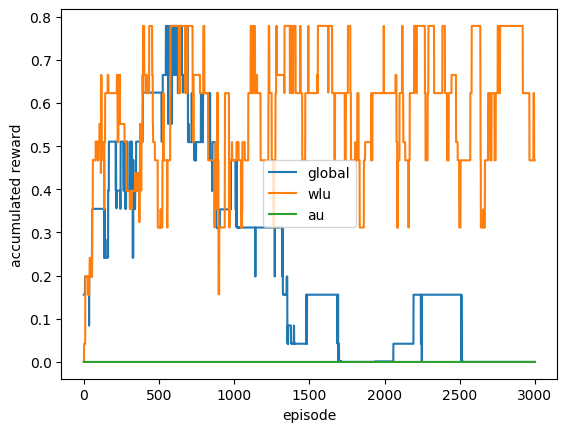

In [19]:
if __name__ == '__main__':
    # different reward functions: global reward, wlu difference rewards, au difference rewards
    reward_funs=[
            "global" , 
            "wlu",
            "au"
            ]
    iter_num = 5
    nb_agents = 10
    nb_episode = 3000
    mu = 0.5 
    sigma = 1.0

    results = []
    for reward_fun in reward_funs:
        results = []
        for it in range(iter_num):
            grid_env = GSD(mu=mu, sigma=sigma)
            policy = EpsGreedyQPolicy(epsilon=0.1)

            agents = []
            for i in range(nb_agents):
                agent = LearningAgent(aid=i, actions=grid_env.actions,  policy=policy)
                agents.append(agent)

            reward_history = []
            for episode in range(nb_episode):
                episode_reward = []
                actions = []
                rewards = {}

                for agent in agents:
                    action = agent.act()
                    actions.append(action)

                _, G = grid_env.step(actions)

                # Grobal Reward
                if reward_fun == "global":
                    for agent in agents:
                        rewards[agent.aid] = G

                # Difference Rewards
                elif reward_fun == "wlu":
                    rewards = wlu_reward_function(agents, grid_env, actions, G, rewards)
                else:
                    rewards = au_reward_function(agents, grid_env, actions, G, rewards)

                for agent in agents:
                    agent.observe(rewards[agent.aid])

                actions = []
                for agent in agents:
                    action = agent.act(training=False)
                    actions.append(action)
                _, G = grid_env.step(actions)
                reward_history.append(G)

            results.append(copy.deepcopy(reward_history))
        results = np.array(results)
        results = results.mean(axis=0)
        plt.plot(np.arange(len(results)), results, label=reward_fun)

    plt.xlabel("episode")
    plt.ylabel("accumulated reward")
    plt.legend()
    plt.savefig("result.jpg")
    plt.show()